In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(2021)
n = 1000
#np.rand 從0 1的均勻分配隨機抽出
#np.randn 從standard normal(平均0 變異1)分配隨機抽出
def f_x(x):
    y = 0.2 + 0.4 * x** + 0.3* x * np.sin(15 * x) 
    return y
x = np.linspace(0,1, num = 3000)
y = f_x(x)

# 隨便生成一個函數 並用NN來近似

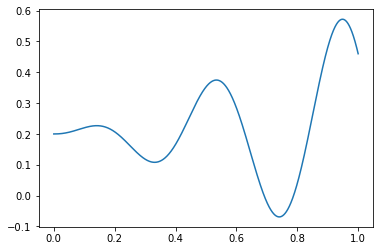

In [3]:
plt.plot(x,y)

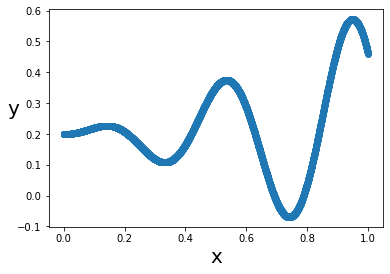

In [4]:
plt.scatter(x,y)
plt.xlabel('x',fontsize=20)
plt.ylabel('y',fontsize=20,rotation=0)
plt.show()



# 正式開使建構模型
1. 將data區分成train, vaildation, test set
2. 模型訓練
3. 評斷模型表現

In [5]:
# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [6]:
class My_Dataset(Dataset):
    def __init__(self,data , mode = 'train'):
        self.mode = mode
        self.test_data_length = config['test_data_length']
        self.train_data_length = len(data) - self.test_data_length
        if self.mode == 'test': 
            self.data = torch.FloatTensor(data[-self.test_data_length::,0])
            
        else:  
            #取70%的data point做訓練
            self.vaild_data_length = round(self.train_data_length * 0.7)
            if self.mode == 'train':
                self.data = torch.FloatTensor(data[0:self.vaild_data_length,0])
                self.target = torch.FloatTensor(data[0:self.vaild_data_length,1])
            elif self.mode == 'vaildation':
                self.data = torch.FloatTensor(data[self.vaild_data_length:self.train_data_length,0])
                self.target = torch.FloatTensor(data[self.vaild_data_length:self.train_data_length,1])
#         self.data = \
#             (self.data - self.data.mean(dim=0, keepdim=True)) \
#             / self.data.std(dim=0, keepdim=True)


    def __getitem__(self, index):
        
        if self.mode in ['train', 'vaildation']:
            return torch.unsqueeze(self.data[index], 0), self.target[index]
        else:
            
            return torch.unsqueeze(self.data[index], 0)
            
    def __len__(self): 
        # Returns the size of the dataset
        return len(self.data)

In [7]:
def prep_dataloader(data, mode, batch_size, n_jobs=0):
    ''' Generates a dataset, then is put into a dataloader. '''
    dataset = My_Dataset(data, mode=mode)  # Construct dataset
    dataloader = DataLoader(
        dataset, batch_size,
        shuffle=(mode == 'train'), drop_last=True,
        num_workers=n_jobs, pin_memory=True)                            # Construct dataloader
    return dataloader

將data丟進pytorch所用的dataset物件中，方便後續模型訓練時的資料提取  
我們來看一下資料的樣子

In [8]:
dataset = np.hstack((x.reshape(3000,1),y.reshape(3000,1)))
dataset[0:11]

array([[0.        , 0.2       ],
       [0.00033344, 0.20000006],
       [0.00066689, 0.2000003 ],
       [0.00100033, 0.20000076],
       [0.00133378, 0.20000146],
       [0.00166722, 0.20000245],
       [0.00200067, 0.20000372],
       [0.00233411, 0.20000531],
       [0.00266756, 0.20000721],
       [0.003001  , 0.20000946],
       [0.00333444, 0.20001205]])

In [13]:
tr_set = prep_dataloader(dataset, 'train', config['batch_size'])
for a,b in tr_set:
    print(a.shape)
    print(b.shape)

torch.Size([128, 1])
torch.Size([128])
torch.Size([128, 1])
torch.Size([128])
torch.Size([128, 1])
torch.Size([128])
torch.Size([128, 1])
torch.Size([128])
torch.Size([128, 1])
torch.Size([128])
torch.Size([128, 1])
torch.Size([128])
torch.Size([128, 1])
torch.Size([128])
torch.Size([128, 1])
torch.Size([128])
torch.Size([128, 1])
torch.Size([128])
torch.Size([128, 1])
torch.Size([128])
torch.Size([128, 1])
torch.Size([128])
torch.Size([128, 1])
torch.Size([128])
torch.Size([128, 1])
torch.Size([128])
torch.Size([128, 1])
torch.Size([128])


In [21]:
class Fully_connect_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
        nn.Linear(1,500),
        nn.ReLU(),
        nn.Linear(500,64),
        nn.ReLU(),
        nn.Linear(64,1),
        nn.Sigmoid()
        )
    
        self.criterion = nn.MSELoss(reduction='mean')
    
    def forward(self, x):
        x = self.net(x)
        return x
    
    def cal_loss(self, pred, target):
        return self.criterion(pred, target)

正式來架構NN模型  
在這邊我們設定了NN架構為  
input(1個x value) -> 300個neuron的hidden layer -> 32個neuron的hidden layer -> output(1個y_hat value)  

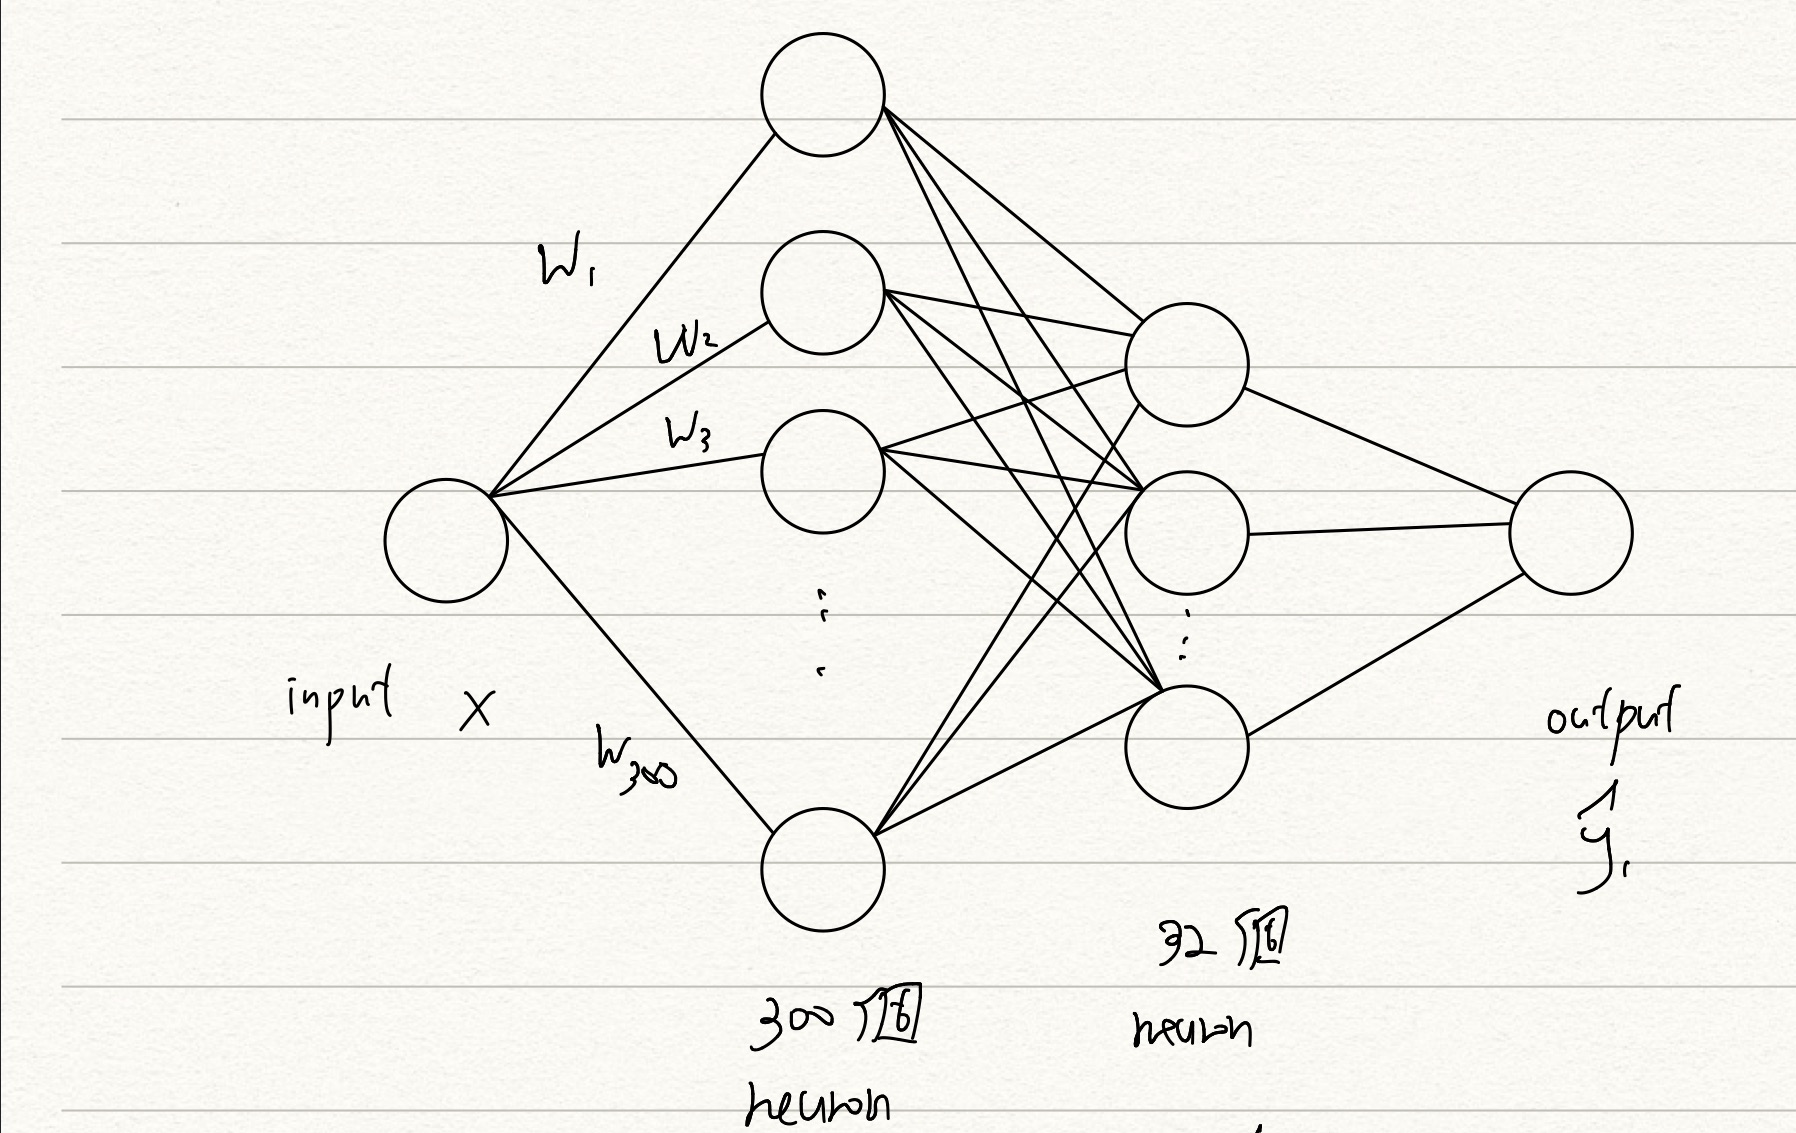

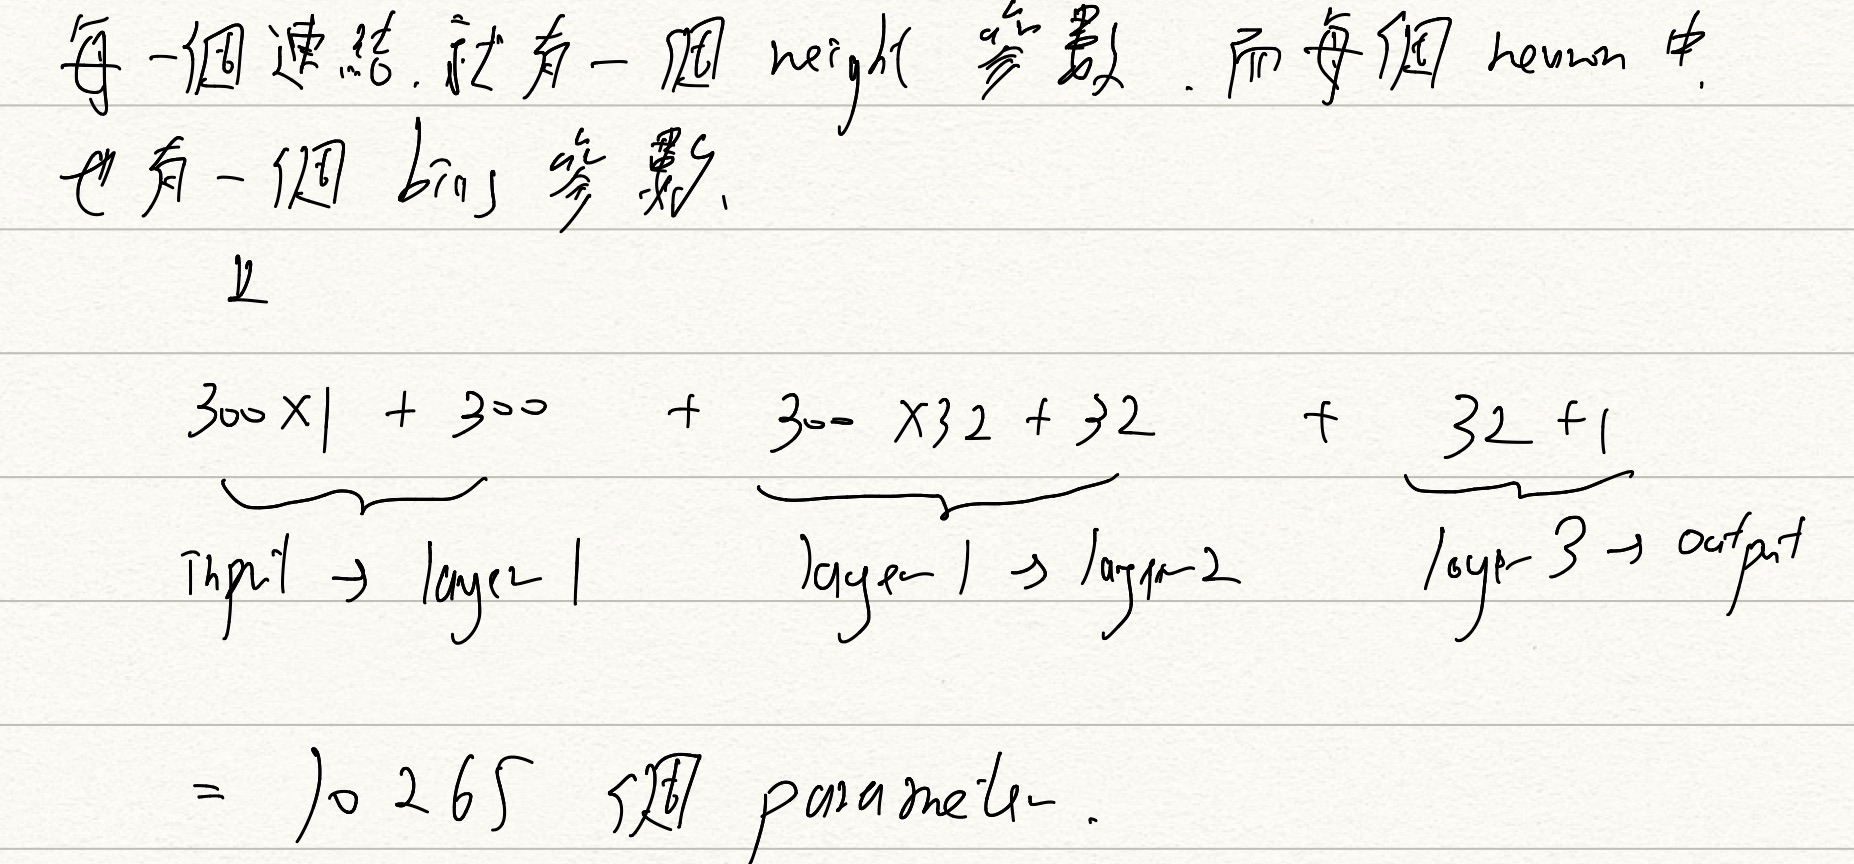

In [22]:
def train(tr_set, dv_set, model, config):
    ''' DNN training '''

    n_epochs = config['n_epochs']  # Maximum number of epochs

    # Setup optimizer
    optimizer = getattr(torch.optim, config['optimizer'])(
        model.parameters(), **config['optim_hparas'])

    min_mse = 1000.
    loss_record = {'train': [], 'dev': []}      # for recording training loss
    early_stop_cnt = 0
    epoch = 0
    while epoch < n_epochs:
        model.train()                           # set model to training mode
        for x, y in tr_set:                     # iterate through the dataloader
            optimizer.zero_grad()               # set gradient to zero cleaning grad before
            pred = model(x)                    # forward pass (compute output)
            pred = torch.flatten(pred)
            MSE = model.cal_loss(pred, y)
            MSE.backward()                 # compute gradient (backpropagation)
            optimizer.step()                    # update model with optimizer
            loss_record['train'].append(MSE.detach().cpu().item())

        # After each epoch, test your model on the validation (development) set.
        dev_mse = dev(dv_set, model)
        if dev_mse < min_mse:
            # Save model if your model improved
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, loss = {:.6f})'
                .format(epoch + 1, min_mse))
            #torch.save(model.state_dict(), config['save_path'])  # Save model to specified path
            early_stop_cnt = 0
        else:
            early_stop_cnt += 1
            #print(f'now epoch: {epoch + 1}, current loss = {min_mse}')

        epoch += 1
        loss_record['dev'].append(dev_mse)
        if early_stop_cnt > config['early_stop']:
            # Stop training if your model stops improving for "config['early_stop']" epochs.
            break

    print('Finished training after {} epochs'.format(epoch))
    return min_mse, loss_record


def dev(dv_set, model):
    model.eval()                                # set model to evalutation mode
    total_loss = 0
    for x, y in dv_set:                         # iterate through the dataloader
        with torch.no_grad():                   # disable gradient calculation
            pred = model(x)                     # forward pass (compute output)
            pred = torch.flatten(pred)
            MSE = model.cal_loss(pred, y)  # compute loss
        total_loss += MSE.detach().cpu().item() * len(x)  # accumulate loss
    total_loss = total_loss / len(dv_set.dataset)              # compute averaged loss

    return total_loss

def test(tt_set, model):
    model.eval()                                # set model to evalutation mode
    preds = []
    for x in tt_set:                            # iterate through the dataloader
        with torch.no_grad():                   # disable gradient calculation
            
            pred = model(x)                     # forward pass (compute output)
            pred = torch.flatten(pred)
            preds.append(pred.detach().cpu())   # collect prediction
    preds = torch.cat(preds, dim=0).numpy()     # concatenate all predictions and convert to a numpy array
    return preds




所謂training的過程就是  
將train data丟進model中(note: model的原始參數是random從常態分配中抽出)
model會產生出output，也就是model的預測結果
(整個過程就是 feed forward的概念，將input data一層一層的推向output layer)
再將model output的結果與真實的y(也就是truth)比較 計算是該data的cost


In [29]:
config = {
    'n_epochs': 5000,                # maximum number of epochs
    'batch_size': 64,                # mini-batch size for dataloader
    'test_data_length':300,
    'optimizer': 'SGD',              # optimization algorithm (optimizer in torch.optim)
    'optim_hparas': {                # hyper-parameters for the optimizer (depends on which optimizer you are using)
        'lr': 0.01                # learning rate of SGD
        #'weight_decay':0.06,         # L2 regulation 
        #'momentum': 0.9,            # momentum for SGD
    },
    'early_stop': 500             # early stopping epochs (the number epochs since your model's last improvement) # your model will be saved here
}

# 正式開始訓練模型

In [505]:
# dataset = np.hstack((x.reshape(1000,1),y.reshape(1000,1)))
# np.random.shuffle(dataset)
# dataset

In [506]:
# tr_set = prep_dataloader(dataset, 'train', config['batch_size'])
# for a,b in tr_set:
#     print(b.shape)

In [30]:
dataset = np.hstack((x.reshape(3000,1),y.reshape(3000,1)))
np.random.shuffle(dataset)
tr_set = prep_dataloader(dataset, 'train', config['batch_size'])
dv_set = prep_dataloader(dataset, 'vaildation', config['batch_size'])

model = Fully_connect_NN()
model_loss, model_loss_record = train(tr_set, dv_set, model, config)



Saving model (epoch =    1, loss = 0.040806)
Saving model (epoch =    2, loss = 0.031033)
Saving model (epoch =    3, loss = 0.027920)
Saving model (epoch =    4, loss = 0.026749)
Saving model (epoch =    5, loss = 0.026269)
Saving model (epoch =    6, loss = 0.025967)
Saving model (epoch =    7, loss = 0.025788)
Saving model (epoch =    8, loss = 0.025653)
Saving model (epoch =    9, loss = 0.025536)
Saving model (epoch =   10, loss = 0.025428)
Saving model (epoch =   11, loss = 0.025326)
Saving model (epoch =   12, loss = 0.025224)
Saving model (epoch =   13, loss = 0.025130)
Saving model (epoch =   14, loss = 0.025037)
Saving model (epoch =   15, loss = 0.024951)
Saving model (epoch =   16, loss = 0.024868)
Saving model (epoch =   17, loss = 0.024788)
Saving model (epoch =   18, loss = 0.024713)
Saving model (epoch =   19, loss = 0.024637)
Saving model (epoch =   20, loss = 0.024567)
Saving model (epoch =   21, loss = 0.024491)
Saving model (epoch =   22, loss = 0.024418)
Saving mod

Saving model (epoch =  205, loss = 0.021383)
Saving model (epoch =  206, loss = 0.021371)
Saving model (epoch =  207, loss = 0.021368)
Saving model (epoch =  208, loss = 0.021363)
Saving model (epoch =  209, loss = 0.021352)
Saving model (epoch =  211, loss = 0.021337)
Saving model (epoch =  212, loss = 0.021334)
Saving model (epoch =  213, loss = 0.021320)
Saving model (epoch =  214, loss = 0.021304)
Saving model (epoch =  215, loss = 0.021291)
Saving model (epoch =  216, loss = 0.021281)
Saving model (epoch =  218, loss = 0.021265)
Saving model (epoch =  219, loss = 0.021265)
Saving model (epoch =  220, loss = 0.021251)
Saving model (epoch =  221, loss = 0.021244)
Saving model (epoch =  222, loss = 0.021232)
Saving model (epoch =  223, loss = 0.021228)
Saving model (epoch =  224, loss = 0.021213)
Saving model (epoch =  225, loss = 0.021199)
Saving model (epoch =  227, loss = 0.021192)
Saving model (epoch =  228, loss = 0.021192)
Saving model (epoch =  229, loss = 0.021172)
Saving mod

Saving model (epoch =  420, loss = 0.019130)
Saving model (epoch =  422, loss = 0.019115)
Saving model (epoch =  423, loss = 0.019092)
Saving model (epoch =  424, loss = 0.019077)
Saving model (epoch =  425, loss = 0.019068)
Saving model (epoch =  427, loss = 0.019048)
Saving model (epoch =  428, loss = 0.019034)
Saving model (epoch =  429, loss = 0.019023)
Saving model (epoch =  431, loss = 0.018997)
Saving model (epoch =  432, loss = 0.018979)
Saving model (epoch =  433, loss = 0.018960)
Saving model (epoch =  434, loss = 0.018949)
Saving model (epoch =  435, loss = 0.018938)
Saving model (epoch =  436, loss = 0.018922)
Saving model (epoch =  437, loss = 0.018911)
Saving model (epoch =  438, loss = 0.018897)
Saving model (epoch =  440, loss = 0.018890)
Saving model (epoch =  441, loss = 0.018863)
Saving model (epoch =  442, loss = 0.018859)
Saving model (epoch =  444, loss = 0.018848)
Saving model (epoch =  445, loss = 0.018805)
Saving model (epoch =  446, loss = 0.018805)
Saving mod

Saving model (epoch =  648, loss = 0.016130)
Saving model (epoch =  649, loss = 0.016122)
Saving model (epoch =  651, loss = 0.016122)
Saving model (epoch =  652, loss = 0.016082)
Saving model (epoch =  653, loss = 0.016075)
Saving model (epoch =  654, loss = 0.016056)
Saving model (epoch =  655, loss = 0.016043)
Saving model (epoch =  656, loss = 0.016042)
Saving model (epoch =  657, loss = 0.016033)
Saving model (epoch =  658, loss = 0.016005)
Saving model (epoch =  659, loss = 0.016003)
Saving model (epoch =  661, loss = 0.015977)
Saving model (epoch =  662, loss = 0.015962)
Saving model (epoch =  664, loss = 0.015944)
Saving model (epoch =  665, loss = 0.015921)
Saving model (epoch =  666, loss = 0.015909)
Saving model (epoch =  667, loss = 0.015891)
Saving model (epoch =  668, loss = 0.015881)
Saving model (epoch =  669, loss = 0.015869)
Saving model (epoch =  670, loss = 0.015854)
Saving model (epoch =  671, loss = 0.015841)
Saving model (epoch =  673, loss = 0.015821)
Saving mod

Saving model (epoch =  880, loss = 0.013531)
Saving model (epoch =  881, loss = 0.013517)
Saving model (epoch =  882, loss = 0.013507)
Saving model (epoch =  883, loss = 0.013496)
Saving model (epoch =  884, loss = 0.013496)
Saving model (epoch =  885, loss = 0.013478)
Saving model (epoch =  886, loss = 0.013474)
Saving model (epoch =  887, loss = 0.013458)
Saving model (epoch =  888, loss = 0.013455)
Saving model (epoch =  889, loss = 0.013442)
Saving model (epoch =  890, loss = 0.013432)
Saving model (epoch =  891, loss = 0.013427)
Saving model (epoch =  892, loss = 0.013409)
Saving model (epoch =  893, loss = 0.013407)
Saving model (epoch =  894, loss = 0.013391)
Saving model (epoch =  895, loss = 0.013385)
Saving model (epoch =  896, loss = 0.013374)
Saving model (epoch =  897, loss = 0.013363)
Saving model (epoch =  898, loss = 0.013353)
Saving model (epoch =  900, loss = 0.013341)
Saving model (epoch =  901, loss = 0.013328)
Saving model (epoch =  903, loss = 0.013306)
Saving mod

Saving model (epoch = 1114, loss = 0.011310)
Saving model (epoch = 1115, loss = 0.011297)
Saving model (epoch = 1116, loss = 0.011276)
Saving model (epoch = 1117, loss = 0.011261)
Saving model (epoch = 1118, loss = 0.011260)
Saving model (epoch = 1119, loss = 0.011231)
Saving model (epoch = 1120, loss = 0.011219)
Saving model (epoch = 1121, loss = 0.011203)
Saving model (epoch = 1122, loss = 0.011192)
Saving model (epoch = 1123, loss = 0.011171)
Saving model (epoch = 1124, loss = 0.011155)
Saving model (epoch = 1125, loss = 0.011144)
Saving model (epoch = 1126, loss = 0.011135)
Saving model (epoch = 1127, loss = 0.011112)
Saving model (epoch = 1128, loss = 0.011106)
Saving model (epoch = 1129, loss = 0.011086)
Saving model (epoch = 1130, loss = 0.011073)
Saving model (epoch = 1131, loss = 0.011072)
Saving model (epoch = 1132, loss = 0.011045)
Saving model (epoch = 1133, loss = 0.011032)
Saving model (epoch = 1135, loss = 0.011010)
Saving model (epoch = 1136, loss = 0.011004)
Saving mod

Saving model (epoch = 1344, loss = 0.009103)
Saving model (epoch = 1346, loss = 0.009087)
Saving model (epoch = 1348, loss = 0.009069)
Saving model (epoch = 1349, loss = 0.009060)
Saving model (epoch = 1350, loss = 0.009053)
Saving model (epoch = 1352, loss = 0.009037)
Saving model (epoch = 1353, loss = 0.009029)
Saving model (epoch = 1354, loss = 0.009020)
Saving model (epoch = 1355, loss = 0.009013)
Saving model (epoch = 1356, loss = 0.009007)
Saving model (epoch = 1358, loss = 0.009000)
Saving model (epoch = 1359, loss = 0.008980)
Saving model (epoch = 1361, loss = 0.008964)
Saving model (epoch = 1362, loss = 0.008955)
Saving model (epoch = 1364, loss = 0.008947)
Saving model (epoch = 1365, loss = 0.008931)
Saving model (epoch = 1367, loss = 0.008917)
Saving model (epoch = 1368, loss = 0.008911)
Saving model (epoch = 1369, loss = 0.008908)
Saving model (epoch = 1370, loss = 0.008891)
Saving model (epoch = 1371, loss = 0.008888)
Saving model (epoch = 1372, loss = 0.008882)
Saving mod

Saving model (epoch = 1602, loss = 0.007166)
Saving model (epoch = 1603, loss = 0.007163)
Saving model (epoch = 1604, loss = 0.007150)
Saving model (epoch = 1607, loss = 0.007142)
Saving model (epoch = 1608, loss = 0.007129)
Saving model (epoch = 1609, loss = 0.007116)
Saving model (epoch = 1612, loss = 0.007094)
Saving model (epoch = 1613, loss = 0.007088)
Saving model (epoch = 1616, loss = 0.007067)
Saving model (epoch = 1619, loss = 0.007049)
Saving model (epoch = 1621, loss = 0.007046)
Saving model (epoch = 1622, loss = 0.007026)
Saving model (epoch = 1623, loss = 0.007022)
Saving model (epoch = 1624, loss = 0.007013)
Saving model (epoch = 1627, loss = 0.006996)
Saving model (epoch = 1628, loss = 0.006985)
Saving model (epoch = 1629, loss = 0.006984)
Saving model (epoch = 1630, loss = 0.006971)
Saving model (epoch = 1632, loss = 0.006960)
Saving model (epoch = 1634, loss = 0.006946)
Saving model (epoch = 1636, loss = 0.006941)
Saving model (epoch = 1637, loss = 0.006936)
Saving mod

Saving model (epoch = 1874, loss = 0.005476)
Saving model (epoch = 1875, loss = 0.005471)
Saving model (epoch = 1876, loss = 0.005461)
Saving model (epoch = 1878, loss = 0.005451)
Saving model (epoch = 1880, loss = 0.005440)
Saving model (epoch = 1881, loss = 0.005437)
Saving model (epoch = 1882, loss = 0.005427)
Saving model (epoch = 1883, loss = 0.005422)
Saving model (epoch = 1884, loss = 0.005418)
Saving model (epoch = 1887, loss = 0.005401)
Saving model (epoch = 1888, loss = 0.005395)
Saving model (epoch = 1891, loss = 0.005379)
Saving model (epoch = 1892, loss = 0.005375)
Saving model (epoch = 1894, loss = 0.005363)
Saving model (epoch = 1896, loss = 0.005354)
Saving model (epoch = 1897, loss = 0.005352)
Saving model (epoch = 1898, loss = 0.005341)
Saving model (epoch = 1900, loss = 0.005336)
Saving model (epoch = 1901, loss = 0.005327)
Saving model (epoch = 1903, loss = 0.005314)
Saving model (epoch = 1904, loss = 0.005309)
Saving model (epoch = 1905, loss = 0.005308)
Saving mod

Saving model (epoch = 2147, loss = 0.004164)
Saving model (epoch = 2148, loss = 0.004156)
Saving model (epoch = 2149, loss = 0.004149)
Saving model (epoch = 2150, loss = 0.004148)
Saving model (epoch = 2151, loss = 0.004138)
Saving model (epoch = 2152, loss = 0.004138)
Saving model (epoch = 2153, loss = 0.004132)
Saving model (epoch = 2155, loss = 0.004124)
Saving model (epoch = 2156, loss = 0.004118)
Saving model (epoch = 2157, loss = 0.004115)
Saving model (epoch = 2159, loss = 0.004113)
Saving model (epoch = 2160, loss = 0.004102)
Saving model (epoch = 2164, loss = 0.004095)
Saving model (epoch = 2166, loss = 0.004081)
Saving model (epoch = 2167, loss = 0.004073)
Saving model (epoch = 2169, loss = 0.004069)
Saving model (epoch = 2171, loss = 0.004060)
Saving model (epoch = 2173, loss = 0.004053)
Saving model (epoch = 2176, loss = 0.004040)
Saving model (epoch = 2177, loss = 0.004035)
Saving model (epoch = 2178, loss = 0.004030)
Saving model (epoch = 2179, loss = 0.004027)
Saving mod

Saving model (epoch = 2426, loss = 0.003186)
Saving model (epoch = 2427, loss = 0.003181)
Saving model (epoch = 2429, loss = 0.003172)
Saving model (epoch = 2430, loss = 0.003172)
Saving model (epoch = 2431, loss = 0.003169)
Saving model (epoch = 2432, loss = 0.003168)
Saving model (epoch = 2434, loss = 0.003164)
Saving model (epoch = 2435, loss = 0.003157)
Saving model (epoch = 2436, loss = 0.003155)
Saving model (epoch = 2437, loss = 0.003150)
Saving model (epoch = 2440, loss = 0.003143)
Saving model (epoch = 2442, loss = 0.003141)
Saving model (epoch = 2443, loss = 0.003132)
Saving model (epoch = 2444, loss = 0.003130)
Saving model (epoch = 2447, loss = 0.003122)
Saving model (epoch = 2448, loss = 0.003119)
Saving model (epoch = 2449, loss = 0.003117)
Saving model (epoch = 2450, loss = 0.003115)
Saving model (epoch = 2451, loss = 0.003112)
Saving model (epoch = 2452, loss = 0.003108)
Saving model (epoch = 2453, loss = 0.003108)
Saving model (epoch = 2455, loss = 0.003106)
Saving mod

Saving model (epoch = 2700, loss = 0.002528)
Saving model (epoch = 2702, loss = 0.002527)
Saving model (epoch = 2703, loss = 0.002521)
Saving model (epoch = 2704, loss = 0.002519)
Saving model (epoch = 2706, loss = 0.002518)
Saving model (epoch = 2707, loss = 0.002518)
Saving model (epoch = 2708, loss = 0.002517)
Saving model (epoch = 2709, loss = 0.002515)
Saving model (epoch = 2710, loss = 0.002510)
Saving model (epoch = 2711, loss = 0.002506)
Saving model (epoch = 2713, loss = 0.002504)
Saving model (epoch = 2716, loss = 0.002499)
Saving model (epoch = 2717, loss = 0.002498)
Saving model (epoch = 2718, loss = 0.002497)
Saving model (epoch = 2719, loss = 0.002494)
Saving model (epoch = 2720, loss = 0.002492)
Saving model (epoch = 2721, loss = 0.002486)
Saving model (epoch = 2722, loss = 0.002484)
Saving model (epoch = 2723, loss = 0.002482)
Saving model (epoch = 2724, loss = 0.002482)
Saving model (epoch = 2725, loss = 0.002478)
Saving model (epoch = 2726, loss = 0.002478)
Saving mod

Saving model (epoch = 2997, loss = 0.002062)
Saving model (epoch = 2998, loss = 0.002061)
Saving model (epoch = 2999, loss = 0.002059)
Saving model (epoch = 3001, loss = 0.002058)
Saving model (epoch = 3002, loss = 0.002057)
Saving model (epoch = 3004, loss = 0.002055)
Saving model (epoch = 3005, loss = 0.002053)
Saving model (epoch = 3006, loss = 0.002051)
Saving model (epoch = 3007, loss = 0.002049)
Saving model (epoch = 3010, loss = 0.002045)
Saving model (epoch = 3017, loss = 0.002036)
Saving model (epoch = 3020, loss = 0.002035)
Saving model (epoch = 3022, loss = 0.002031)
Saving model (epoch = 3025, loss = 0.002028)
Saving model (epoch = 3027, loss = 0.002025)
Saving model (epoch = 3028, loss = 0.002023)
Saving model (epoch = 3031, loss = 0.002022)
Saving model (epoch = 3032, loss = 0.002021)
Saving model (epoch = 3034, loss = 0.002017)
Saving model (epoch = 3037, loss = 0.002013)
Saving model (epoch = 3040, loss = 0.002013)
Saving model (epoch = 3041, loss = 0.002012)
Saving mod

Saving model (epoch = 3341, loss = 0.001724)
Saving model (epoch = 3342, loss = 0.001722)
Saving model (epoch = 3343, loss = 0.001721)
Saving model (epoch = 3344, loss = 0.001720)
Saving model (epoch = 3345, loss = 0.001719)
Saving model (epoch = 3347, loss = 0.001719)
Saving model (epoch = 3348, loss = 0.001714)
Saving model (epoch = 3352, loss = 0.001712)
Saving model (epoch = 3354, loss = 0.001710)
Saving model (epoch = 3356, loss = 0.001709)
Saving model (epoch = 3358, loss = 0.001707)
Saving model (epoch = 3360, loss = 0.001707)
Saving model (epoch = 3363, loss = 0.001705)
Saving model (epoch = 3364, loss = 0.001704)
Saving model (epoch = 3365, loss = 0.001703)
Saving model (epoch = 3366, loss = 0.001701)
Saving model (epoch = 3367, loss = 0.001699)
Saving model (epoch = 3370, loss = 0.001698)
Saving model (epoch = 3371, loss = 0.001698)
Saving model (epoch = 3372, loss = 0.001697)
Saving model (epoch = 3373, loss = 0.001697)
Saving model (epoch = 3374, loss = 0.001696)
Saving mod

Saving model (epoch = 3715, loss = 0.001479)
Saving model (epoch = 3717, loss = 0.001478)
Saving model (epoch = 3720, loss = 0.001476)
Saving model (epoch = 3723, loss = 0.001474)
Saving model (epoch = 3726, loss = 0.001474)
Saving model (epoch = 3728, loss = 0.001473)
Saving model (epoch = 3729, loss = 0.001471)
Saving model (epoch = 3731, loss = 0.001471)
Saving model (epoch = 3732, loss = 0.001470)
Saving model (epoch = 3735, loss = 0.001469)
Saving model (epoch = 3741, loss = 0.001467)
Saving model (epoch = 3742, loss = 0.001466)
Saving model (epoch = 3743, loss = 0.001465)
Saving model (epoch = 3745, loss = 0.001465)
Saving model (epoch = 3747, loss = 0.001463)
Saving model (epoch = 3748, loss = 0.001461)
Saving model (epoch = 3751, loss = 0.001460)
Saving model (epoch = 3754, loss = 0.001458)
Saving model (epoch = 3755, loss = 0.001457)
Saving model (epoch = 3756, loss = 0.001456)
Saving model (epoch = 3761, loss = 0.001456)
Saving model (epoch = 3762, loss = 0.001456)
Saving mod

Saving model (epoch = 4207, loss = 0.001269)
Saving model (epoch = 4208, loss = 0.001268)
Saving model (epoch = 4211, loss = 0.001268)
Saving model (epoch = 4212, loss = 0.001266)
Saving model (epoch = 4215, loss = 0.001265)
Saving model (epoch = 4217, loss = 0.001263)
Saving model (epoch = 4220, loss = 0.001263)
Saving model (epoch = 4222, loss = 0.001262)
Saving model (epoch = 4224, loss = 0.001261)
Saving model (epoch = 4226, loss = 0.001261)
Saving model (epoch = 4228, loss = 0.001260)
Saving model (epoch = 4229, loss = 0.001259)
Saving model (epoch = 4232, loss = 0.001259)
Saving model (epoch = 4234, loss = 0.001257)
Saving model (epoch = 4241, loss = 0.001255)
Saving model (epoch = 4243, loss = 0.001255)
Saving model (epoch = 4246, loss = 0.001254)
Saving model (epoch = 4247, loss = 0.001254)
Saving model (epoch = 4253, loss = 0.001252)
Saving model (epoch = 4256, loss = 0.001250)
Saving model (epoch = 4260, loss = 0.001249)
Saving model (epoch = 4262, loss = 0.001248)
Saving mod

Saving model (epoch = 4742, loss = 0.001111)
Saving model (epoch = 4744, loss = 0.001111)
Saving model (epoch = 4747, loss = 0.001110)
Saving model (epoch = 4749, loss = 0.001108)
Saving model (epoch = 4753, loss = 0.001107)
Saving model (epoch = 4757, loss = 0.001107)
Saving model (epoch = 4764, loss = 0.001106)
Saving model (epoch = 4766, loss = 0.001106)
Saving model (epoch = 4767, loss = 0.001104)
Saving model (epoch = 4771, loss = 0.001103)
Saving model (epoch = 4773, loss = 0.001103)
Saving model (epoch = 4781, loss = 0.001102)
Saving model (epoch = 4785, loss = 0.001102)
Saving model (epoch = 4786, loss = 0.001100)
Saving model (epoch = 4787, loss = 0.001099)
Saving model (epoch = 4795, loss = 0.001097)
Saving model (epoch = 4798, loss = 0.001097)
Saving model (epoch = 4801, loss = 0.001096)
Saving model (epoch = 4804, loss = 0.001096)
Saving model (epoch = 4807, loss = 0.001096)
Saving model (epoch = 4808, loss = 0.001095)
Saving model (epoch = 4809, loss = 0.001095)
Saving mod

In [31]:
tt_set = prep_dataloader(dataset, 'test', batch_size = 300)
preds = test(tt_set, model)

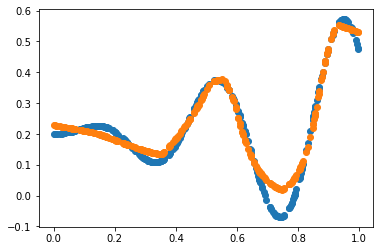

In [32]:
for i in tt_set:
    truth = f_x(i)
    plt.scatter(i,truth)
    plt.scatter(i,preds)